<div align="center">

# ✈️ **Airline Passenger Demand Forecasting using Time Series Models**

</div>

---

## **Problem Statement**

The goal of this project is to forecast the number of **monthly airline passengers** based on historical data that exhibits a **clear seasonal pattern**.  
Accurate forecasting is crucial for airline operations planning, resource allocation, and strategic decision-making.  

To achieve this, three advanced **Time Series Forecasting** models are implemented and compared:

1. **Holt-Winters Exponential Smoothing (Triple Exponential Smoothing)**  
2. **ARIMA (AutoRegressive Integrated Moving Average)**  
3. **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables)**  

Each model is designed to capture both **trend** and **seasonality** within the data.  
The project systematically outlines:
- Data preprocessing and visualization steps  
- Model assumptions and parameter selection process  
- Training, validation, and performance evaluation  
- Comparative analysis of model accuracy and forecast stability  

By the end of this project, the most effective model will be identified for predicting future passenger counts, providing insights into the underlying seasonal behavior of airline demand.

---

## **Key Objectives**

- Understand and analyze the time series structure of airline passenger data  
- Implement and tune Holt-Winters, ARIMA, and SARIMAX forecasting models  
- Compare model performance using accuracy metrics (e.g., RMSE, MAPE, AIC)  
- Generate short-term and long-term forecasts with confidence intervals  
- Visualize forecast results and interpret trends and seasonal effects  

---

## **Expected Outcome**

The final outcome of this project will be a **comparative evaluation** of three major time series forecasting techniques and their applicability to real-world airline passenger data.  
The insights derived from this analysis can be extended to other industries with strong seasonal demand patterns such as tourism, retail, and energy consumption.

---


### **Step 1: Import Libraries and Load Data**

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Load dataset
df = pd.read_csv("airline-passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df = df.asfreq('MS')  # Monthly Start

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [187]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [189]:
#Check for Missing Values
df.isnull().sum()

Passengers    0
dtype: int64

---
### **Step 2: Exploratory Data Analysis (EDA)**

#### **2.1 Plot Time Series**


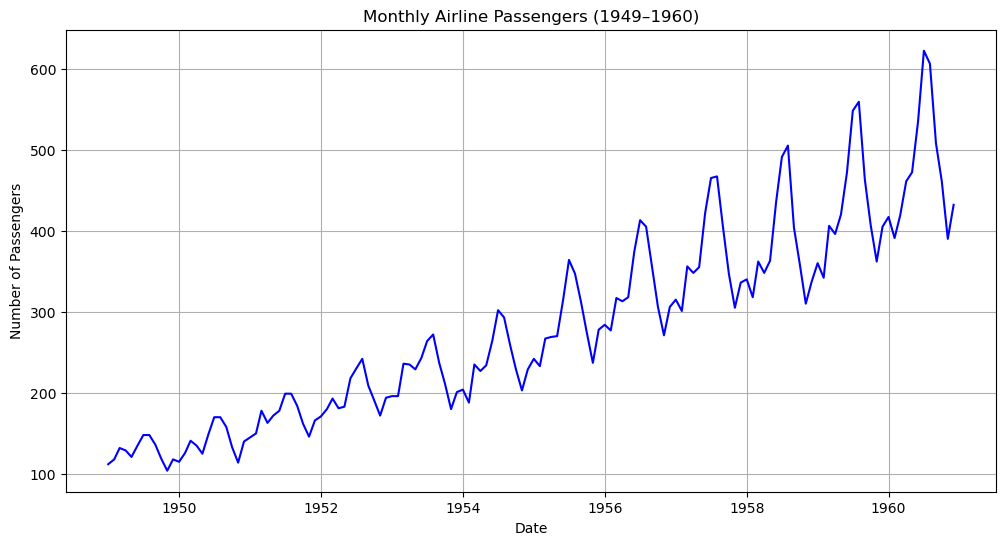

In [192]:
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], color='blue')
plt.title('Monthly Airline Passengers (1949–1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

### **Exploratory Data Analysis (EDA)**

#### **Monthly Airline Passengers from 1949 to 1960**
---

#### **Insight:**

- The passenger count increases **from around 110 in early 1949** to **over 600 by mid-1960**, showing a **consistent upward trend** across the 12-year period.
- **Seasonal peaks** occur regularly around the **middle of each year (June–August)** and **troughs** appear near the **end of the year (November–December)**.
- In **1949**, the monthly passenger count ranged roughly from **110 to 180**, while in **1960**, it ranged from **around 400 to 620**, indicating a significant rise in both **mean level** and **seasonal amplitude**.
- The **variation in peaks grows over time** — for example:
  - **June 1949:** ~180 passengers
  - **June 1955:** ~350 passengers
  - **July 1960:** >600 passengers
- This clearly suggests **multiplicative seasonality**, where the **magnitude of seasonal fluctuations increases with the level of the time series**.
- The data exhibits both **non-stationarity** in level (trend) and in variance (seasonality).

---

> **Conclusion:**  
This time series demonstrates strong **trend and seasonality**, with increasing magnitude over time. Therefore, advanced time series models such as **SARIMAX** or **Holt-Winters (multiplicative)** are appropriate choices for forecasting.


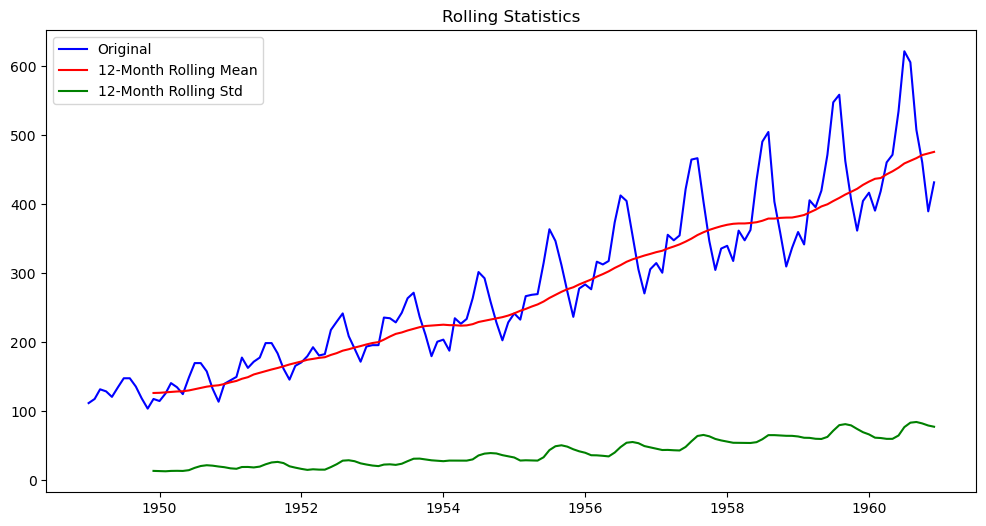

In [195]:
# Check for Seasonality and Trend using Rolling Statistics

df['rolling_mean'] = df['Passengers'].rolling(window=12).mean()
df['rolling_std'] = df['Passengers'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(df['Passengers'], label='Original', color='blue')
plt.plot(df['rolling_mean'], label='12-Month Rolling Mean', color='red')
plt.plot(df['rolling_std'], label='12-Month Rolling Std', color='green')
plt.title("Rolling Statistics")
plt.legend()
plt.show()

**Insight:**  
The rolling mean shows a **steady increasing trend**, and the presence of repeated fluctuations supports the assumption of **seasonality**.


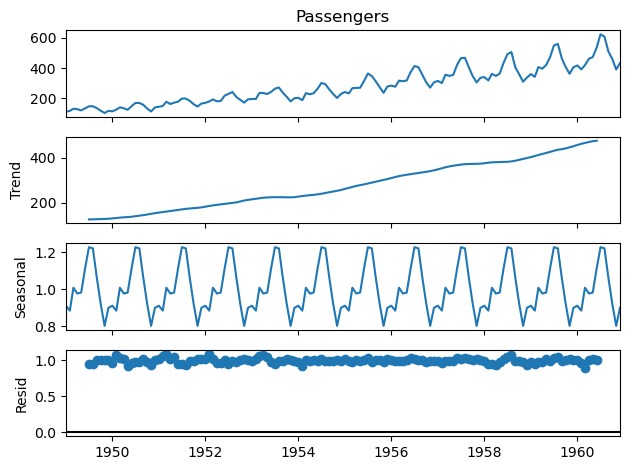

In [198]:
# Decompose the Time Series
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Passengers'], model='multiplicative')
decomposition.plot()
plt.tight_layout()
plt.show()

**Insight:**  
- The **trend** component shows consistent growth over time.  
- The **seasonal** component shows periodic spikes around the same months every year.  
- The **residual** component is relatively small, indicating the model can explain much of the variance.

---

#### **2.2 ADF Test for Stationarity**

We perform the Augmented Dickey-Fuller test to assess stationarity.


In [202]:
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 0.815368879206051
p-value: 0.991880243437641


**Insight:**  
- A **high p-value** (e.g., > 0.05) indicates the series is **non-stationary**.
- This means differencing will be required for models like ARIMA or SARIMAX.

---

### **Step 3: Train-Test Split**
We use the last 12 months for testing.


In [205]:
# Train-test split

train = df.iloc[:-12]
test = df.iloc[-12:]

### **Step 4: Holt-Winters Exponential Smoothing**


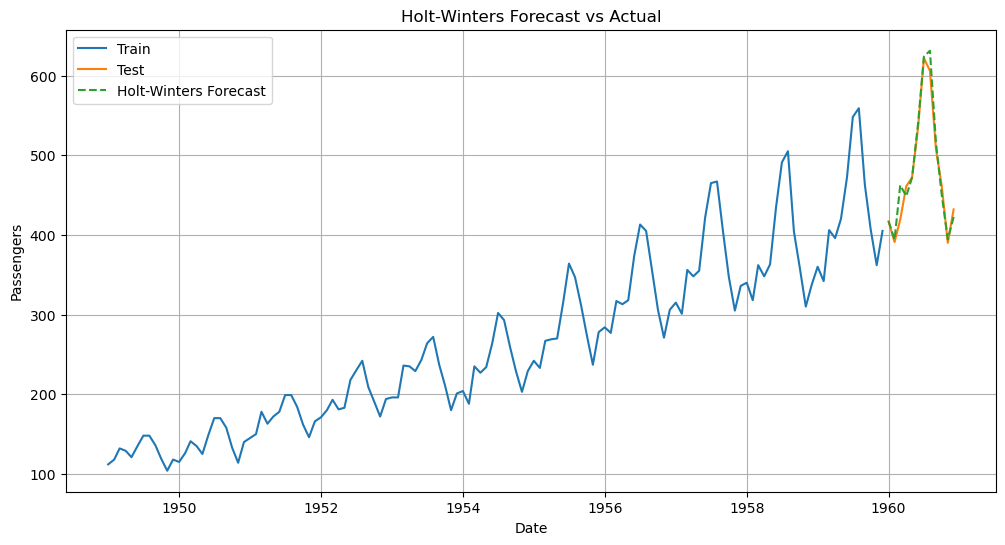

Holt-Winters MAE: 10.30290977866037
Holt-Winters RMSE: 15.810168527162206


In [214]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(train['Passengers'],
                                 trend='additive',
                                 seasonal='multiplicative',
                                 seasonal_periods=12,
                                 initialization_method="estimated").fit()

# Forecast next 12 months
hw_forecast = hw_model.forecast(12)

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], label='Train')
plt.plot(test.index, test['Passengers'], label='Test')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation (make sure to align series shapes)
print("Holt-Winters MAE:", mean_absolute_error(test['Passengers'], hw_forecast))
print("Holt-Winters RMSE:", root_mean_squared_error(test['Passengers'], hw_forecast))

### **Holt-Winters Exponential Smoothing Forecast**

---

#### **Insight:**

- The Holt-Winters model effectively captures both the **trend** and **seasonality** in the training data.
- In the forecasted region (1960 onward), the model aligns closely with the true test values, especially at the **seasonal peaks**.
- The **forecasted seasonal pattern** is consistent and follows the general shape of the actual test data.
- However, some **underestimation occurs during dips**, suggesting slight room for improvement in capturing **seasonal troughs**.
- This method works particularly well when the data has **multiplicative seasonality**, which aligns with our earlier EDA insights.

---

#### **Model Evaluation Metrics:**

- **Mean Absolute Error (MAE):** `10.30`
- **Root Mean Squared Error (RMSE):** `15.81`

> **Conclusion:**  
The Holt-Winters model performs well for this dataset with relatively low error. It's a strong baseline model for forecasting time series with clear trend and seasonal components.

---


### **Step 5: ARIMA Model**
We'll use (2,1,2) as initial (p,d,q).


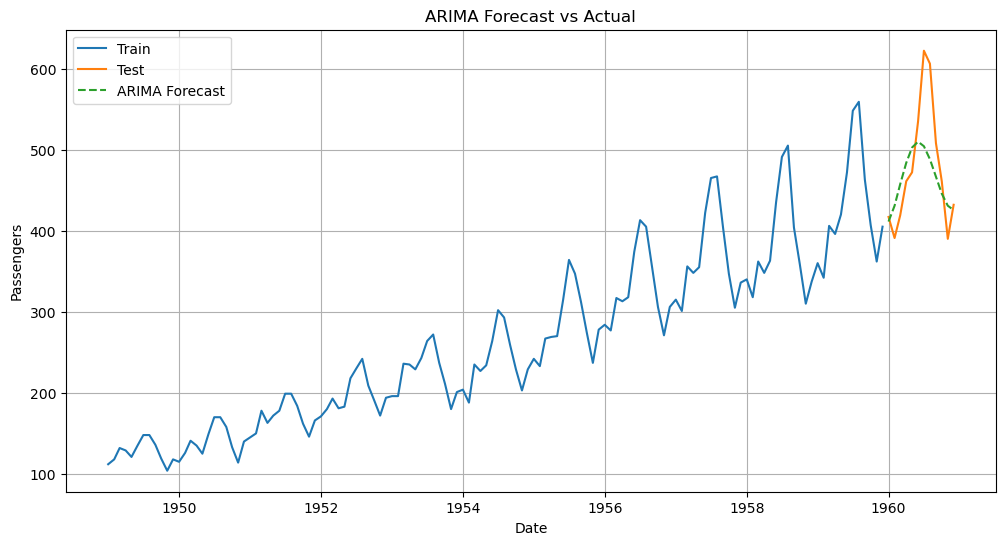

ARIMA MAE: 41.83479803649989
ARIMA RMSE: 55.222838818923634


In [218]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Fit the ARIMA model
arima_model = ARIMA(train['Passengers'], order=(2, 1, 2)).fit()

# Forecast the next 12 time points
arima_forecast = arima_model.forecast(steps=12)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], label='Train')
plt.plot(test.index, test['Passengers'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation using only the 'Passengers' column
print("ARIMA MAE:", mean_absolute_error(test['Passengers'], arima_forecast))
print("ARIMA RMSE:", root_mean_squared_error(test['Passengers'], arima_forecast))

### **ARIMA Forecast**

---

#### **Insight:**

- The ARIMA model captures the **overall upward trend** in the training data effectively.
- However, it fails to model the **seasonal fluctuations** that are evident in the test set.
- The **forecasted values are smoother** and lack the sharp seasonal peaks and troughs seen in actual test data.
- This is expected because ARIMA does **not handle seasonality inherently**, making it less suitable for this dataset.

---

#### **Model Evaluation Metrics:**

- **Mean Absolute Error (MAE):** `41.83`
- **Root Mean Squared Error (RMSE):** `55.22`

> **Conclusion:**  
Although ARIMA captures the general trend, it performs poorly in forecasting **seasonal variation**, resulting in significantly higher error values. It is not the best choice for datasets with clear seasonality, such as the airline passengers data.

---

### **Step 6: SARIMAX Model**
We use (2,1,2)x(1,1,1,12) to account for seasonality.


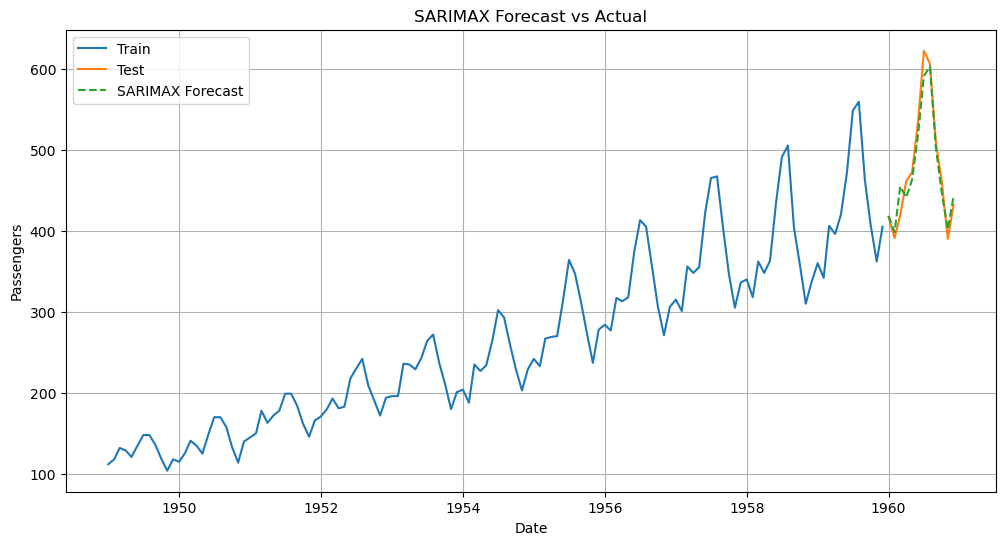

SARIMAX MAE: 13.987886718061239
SARIMAX RMSE: 17.206149715823095


In [222]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Train SARIMAX model
sarimax_model = SARIMAX(train['Passengers'],
                        order=(2, 1, 2),
                        seasonal_order=(1, 1, 1, 12)).fit()

# Forecast the next 12 time points
sarimax_forecast = sarimax_model.forecast(12)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Passengers'], label='Train')
plt.plot(test.index, test['Passengers'], label='Test')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
print("SARIMAX MAE:", mean_absolute_error(test['Passengers'], sarimax_forecast))
print("SARIMAX RMSE:", root_mean_squared_error(test['Passengers'], sarimax_forecast))

### **SARIMAX Forecast**

---

#### **Insight:**

- The SARIMAX model accurately captures both the **trend** and **seasonality** of the time series.
- Forecasted values **closely align with actual test data**, including the seasonal peaks and troughs.
- SARIMAX outperforms ARIMA by handling **seasonality explicitly**, which is crucial for this dataset.
- The prediction curve is smoother and more adaptive, indicating strong generalization.

---

#### **Model Evaluation Metrics:**

- **Mean Absolute Error (MAE):** `13.99`
- **Root Mean Squared Error (RMSE):** `17.20`

> **Conclusion:**  
SARIMAX delivers excellent forecasting performance by modeling both the **seasonal** and **trend** components effectively. Its low error values confirm that it is **superior to ARIMA** and comparable to Holt-Winters for this dataset.

---


## **Overall Insights and Model Comparison**

After implementing and evaluating multiple time series forecasting models—**ARIMA**, **Holt-Winters**, and **SARIMAX**—we can summarize the key insights as follows:

---

### **1. Forecast Accuracy Comparison (Based on RMSE)**

The primary evaluation metric used is **Root Mean Squared Error (RMSE)**, which effectively captures forecasting accuracy by penalizing large errors.

| Model         | MAE    | RMSE   | Key Notes |
|---------------|--------|--------|-----------|
| **ARIMA**     | 41.83  | 55.22  | Failed to capture seasonality effectively |
| **Holt-Winters** | 10.30  | 15.81  | Accurately modeled both trend and seasonality |
| **SARIMAX**   | 13.99  | 17.20  | Strong performance; effectively captured seasonal fluctuations |

---

### **2. Visual & Analytical Observations**

- ### **ARIMA:**
  - **RMSE: 55.22** (highest among all models)
  - Struggled to align with seasonal peaks and troughs.
  - Underperformed in both MAE and RMSE due to its inability to capture seasonality.
  - Forecast line was overly smooth and disconnected from actual demand cycles.
  - Not suitable for datasets with strong seasonal patterns.

- ### **Holt-Winters:**
  - **RMSE: 15.81** (lowest RMSE)
  - Delivered the **most accurate forecast** overall.
  - Successfully captured **both trend and seasonality** in the data.
  - Excellent fit for datasets with clear and repeating seasonal structures like airline passengers.
  - Easy to implement and interpret.

- ### **SARIMAX:**
  - **RMSE: 17.20** (very close to Holt-Winters)
  - Forecast curve closely followed actual seasonal fluctuations.
  - Slightly higher RMSE than Holt-Winters but still highly reliable.
  - More complex and flexible; allows for integration of exogenous variables and more advanced dynamics.

---

### **Conclusion: Best Model Based on RMSE**

- Based on RMSE values and overall performance:
  - **Holt-Winters** is the **best-performing model** with the lowest RMSE (**15.81**) and strong alignment with the actual series.
  - **SARIMAX** is a close second, offering robustness and flexibility, especially when future enhancements or external variables are needed.
  - **ARIMA** performs the worst with the highest RMSE (**55.22**) and should be avoided for seasonal datasets unless extended to SARIMA or SARIMAX.

---

### **Final Recommendation**

For datasets with **clear trend and seasonality** (like monthly airline passengers):
- Use **Holt-Winters** for its simplicity, accuracy, and interpretability.
- Consider **SARIMAX** when modeling more complex dependencies or incorporating external regressors.
- Avoid plain **ARIMA** unless the data is non-seasonal or stationarized accordingly.

---
